In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import random
import networkx as nx
import pandas as pd
import seaborn as sns
from itertools import combinations

from functions import *

In [2]:
OBS, RFID, OBS_name_mapping = prepare_OBS_and_RFID()
OBS.head()

,DateTime,Actor,Recipient,Behavior,Category,Duration,Point,Day
15,2019-06-13 09:50:00,0,7,Grooming,Affiliative,6,NO,13
17,2019-06-13 09:50:00,0,7,Grooming,Affiliative,4,NO,13
19,2019-06-13 09:51:00,7,0,Resting,Affiliative,8,NO,13
20,2019-06-13 09:51:00,7,11,Resting,Affiliative,8,NO,13
21,2019-06-13 09:51:00,0,7,Grooming,Affiliative,36,NO,13


**Мы попробуем посмотреть на взаимодействие обезьян. Очень условно аффилиативное поведение - это про привязанность, агонистическое - про конфликт. Также есть малочисленная категтрия Other, ее мы в рамках этого ноутбука изучать не будем**

In [3]:
OBS[OBS.Recipient.notna()].groupby(['Category', 'Behavior']).size()

Category     Behavior            
Affiliative  Embracing                 58
             Grooming                 436
             Grunting-Lipsmacking     142
             Mounting                  30
             Playing with             771
             Presenting               215
             Resting                 1247
             Touching                 156
Agonistic    Attacking                 10
             Avoiding                   5
             Chasing                   19
             Submission                36
             Supplanting               14
             Threatening               25
Other        Carrying                  13
             Copulating                17
dtype: int64

**Посчитаем clustering coefficient для наших графов**

In [4]:
df_affiliative = OBS[OBS['Category'] == 'Affiliative' ]
df_agonistic = OBS[OBS['Category'] == 'Agonistic' ]
g_affiliative = create_graph_from_time_multi_edges(df_affiliative, 'Actor', 'Recipient', OBS.DateTime.min(), OBS.DateTime.max())
g_agonistic = create_graph_from_time_multi_edges(df_agonistic, 'Actor', 'Recipient', OBS.DateTime.min(), OBS.DateTime.max())

In [5]:
nx.approximation.average_clustering(g_affiliative)

0.931

In [6]:
nx.approximation.average_clustering(g_agonistic)

0.422

In [7]:
df_affiliative.shape

(3055, 8)

In [8]:
df_agonistic.shape

(109, 8)

**Тут все логично - для позитивных взаимодействий коэффициент высокий (граф вообще близок к полному), для конфликтных низкий, в оставшихся графах треугольников нет. Но не очень интересно, потому что размеры у графов разные. Попробуем погенерировать разные подграфы одного размера и применить t-тест**

In [9]:
res = []
index = []

func_list = [nx.approximation.average_clustering, nx.number_connected_components]

for func in func_list: 
    print(func.__name__)
    for sample_size in [20, 35, 50]:
        random_coefs = calculate_func(func, OBS.DateTime.min(), OBS.DateTime.max(), sample_size=sample_size)
        affiliative_coefs = calculate_func(func, OBS.DateTime.min(), OBS.DateTime.max(), df=df_affiliative, sample_size=sample_size)
        agonistic_coefs = calculate_func(func, OBS.DateTime.min(), OBS.DateTime.max(), df=df_agonistic, sample_size=sample_size)
        res.append([np.mean(agonistic_coefs), np.mean(random_coefs), np.mean(affiliative_coefs), st.f_oneway(affiliative_coefs, random_coefs, agonistic_coefs).pvalue])
        index.append(f'{func.__name__} {sample_size}')
        
df_res = pd.DataFrame(res, index=index, columns=['agonistic', 'random', 'affiliative', 'p-value'])
df_res

average_clustering
number_connected_components


,agonistic,random,affiliative,p-value
average_clustering 20,0.05398,0.05181,0.09018,8.398742e-06
average_clustering 35,0.12780,0.13523,0.15789,4.316138e-03
average_clustering 50,0.21319,0.22532,0.25089,6.440531e-04
number_connected_components 20,6.11000,4.25000,6.15000,1.296676e-23
number_connected_components 35,3.16000,1.58000,3.43000,5.895633e-34
number_connected_components 50,1.91000,1.11000,2.56000,2.542166e-35


**В общем, на графах одинакового размера (и со взаимодействиями, близкими по времени) коэффициент кластеризации выше для аффилиативного поведения, чем для агонистического**

**Попробуем сравнить вариативность графов для аффилиатичного и агонистического поведения - насколько сильно они меняются день ото дня**

In [10]:
names = OBS.Actor.unique()
names.sort()
days = OBS['Day'].unique()
days.sort()

In [11]:
matrix_affiliative = create_similarity_matrix(df_affiliative, names, days)
matrix_agonistic = create_similarity_matrix(df_agonistic, names, days)

/home/maria/HSE/Graph/functions.py:125: RuntimeWarning: invalid value encountered in true_divide
  return dot_product / (norm_a * norm_b)


**Смотрим на косинусное сходство (между днями июня) по ребрам для неориентированного графа с кратными ребрами - сначала для аффилиативного поведения, затем для агонистического**

<AxesSubplot:>

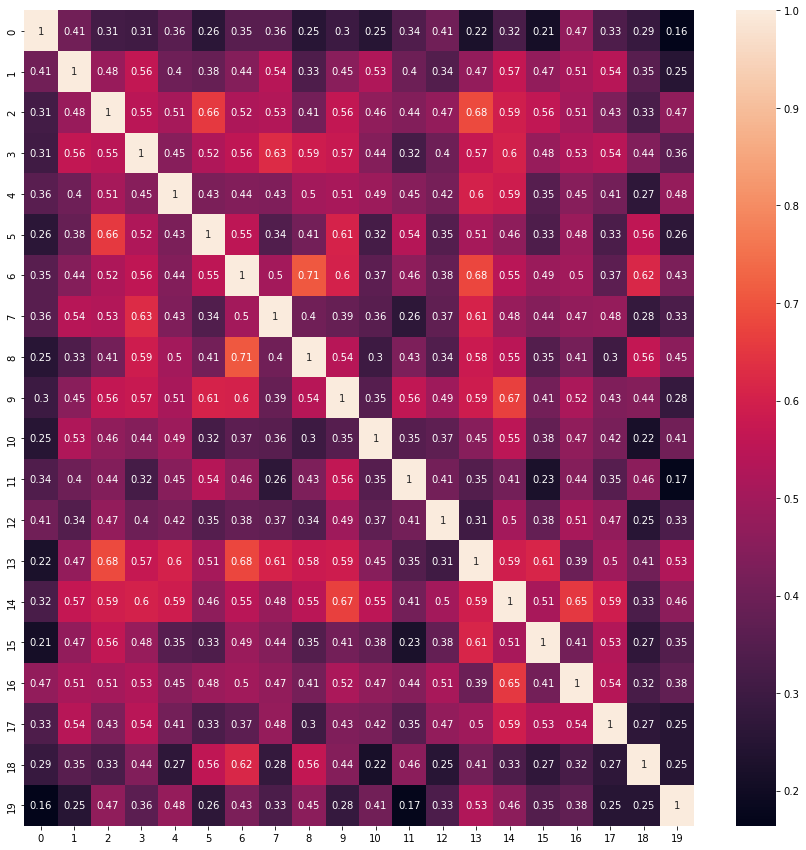

In [12]:
plt.figure(figsize=(15, 15))
sns.heatmap(pd.DataFrame(matrix_affiliative), annot=True)

<AxesSubplot:>

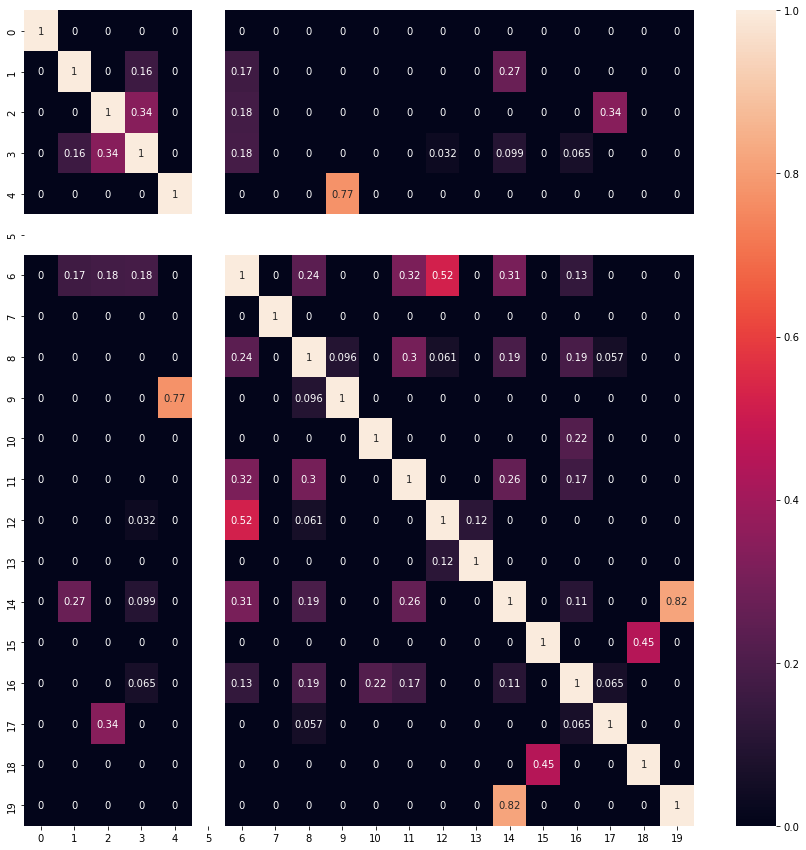

In [13]:
plt.figure(figsize=(15, 15))
sns.heatmap(pd.DataFrame(matrix_agonistic), annot=True)

**Очевидно, агонистических взаимодействий слишком мало. Для аффилиативных же визуально сложно сказать, верно ли, что соседние дни похожи друг на друга сильнее, чем несоседние (то есть что граф аффилиативных взаимодействий меняется за день меньше, чем, например, за неделю). Посмотрим на график среднего косинусного сходства двух дней в зависимости от расстояния между этими днями**

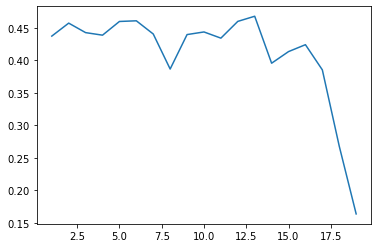

In [18]:
distance_similarity = defaultdict(list)

for i in range(len(days) - 1):
    for j in range(i + 1, len(days)):
        distance_similarity[j - i].append(matrix_affiliative[i, j])
        
xs = distance_similarity.keys()
ys = [np.mean(distance_similarity[key]) for key in distance_similarity]

plt.plot(xs, ys)

**За исключением последней точки (но это краевой эффект, ведь там среднее берется всего по одному числу, ведь лишь два дня находятся на максимальном расстоянии друг от друга) сложно сказать, что график убывает. То есть чисто визуально гипотеза не находит подтверждения: кажется, что дни отличаются друг от друга более или менее одинаково.**